# Chebyshev Interpolation with funpy

This notebook demonstrates the key concepts from the interpolation section using **funpy**, a Python library for automatic function approximation using Chebyshev polynomials.

**Key concepts covered:**
1. Creating function representations from lambda functions
2. Automatic adaptive discretization
3. Values ↔ Coefficients via DCT
4. Coefficient decay and smoothness
5. Differentiation and integration
6. Runge phenomenon: Chebyshev vs equidistant nodes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from funpy import Fun

# For nicer plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 1. Creating Functions with funpy

The `Fun` class represents a function using its Chebyshev series. It automatically:
1. Samples the function at Chebyshev points
2. Computes Chebyshev coefficients via DCT
3. Adaptively chooses the number of points until coefficients decay to machine precision

Function represented with 20 Chebyshev coefficients
Domain: [-1  1]


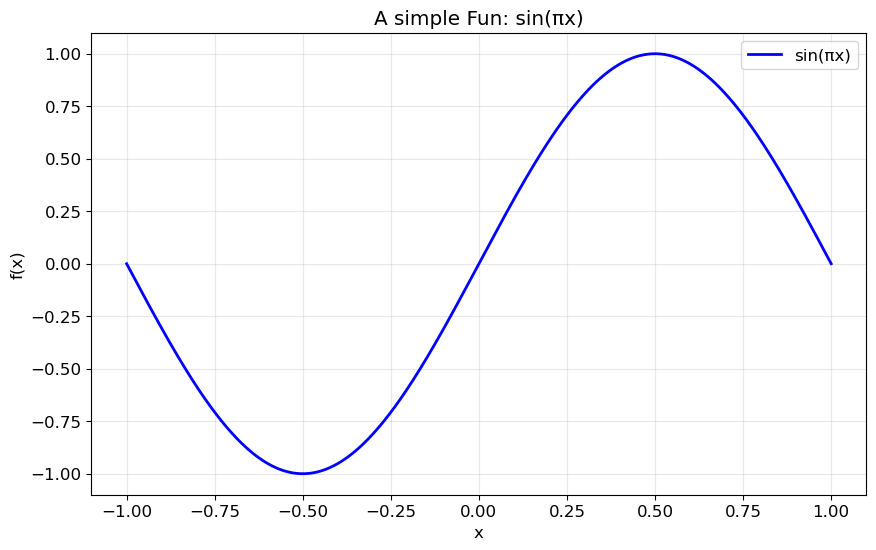

In [2]:
# Create a Fun from a lambda function
f = Fun(lambda x: np.sin(np.pi * x), [-1, 1])

print(f"Function represented with {f.shape[0]} Chebyshev coefficients")
print(f"Domain: {f.domain}")

# Plot the function
xx = np.linspace(-1, 1, 500)
plt.plot(xx, f(xx), 'b-', linewidth=2, label='sin(πx)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('A simple Fun: sin(πx)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 2. Chebyshev Points

funpy uses **2nd-kind Chebyshev points** (extrema of $T_{n-1}$):
$$x_k = \cos\left(\frac{k\pi}{n-1}\right), \quad k = 0, 1, \ldots, n-1$$

These points cluster near the endpoints—exactly where Runge's phenomenon causes problems with equally spaced nodes!

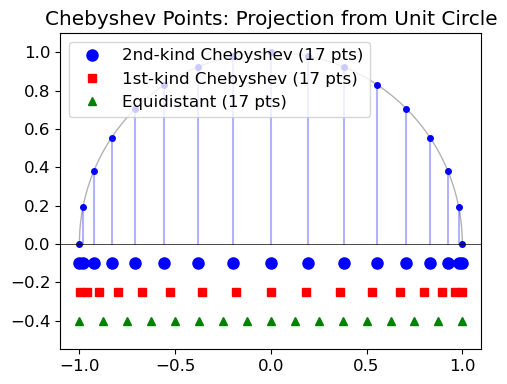

Notice how Chebyshev points cluster near ±1, while equidistant points are evenly spaced.


In [3]:
from funpy.cheb import chebpts_type1, chebpts_type2

n = 17  # Number of points

# 2nd-kind: extrema of T_{n-1}, include endpoints (used for values)
x2, w2, v2, t2 = chebpts_type2(n)

# 1st-kind: roots of T_n, exclude endpoints
x1, w1, v1, t1 = chebpts_type1(n)

# Equidistant points for comparison
xe = np.linspace(-1, 1, n)

# Visualization
fig, ax = plt.subplots(figsize=(12, 4))

# Plot on a circle to show the projection
theta = np.linspace(0, np.pi, 200)
ax.plot(np.cos(theta), np.sin(theta), 'k-', alpha=0.3, linewidth=1)

# Show projections from circle
for xi in x2:
    theta_i = np.arccos(xi)
    ax.plot([xi, xi], [0, np.sin(theta_i)], 'b-', alpha=0.3)
    ax.plot(xi, np.sin(theta_i), 'bo', markersize=4)

# Plot the three point distributions
ax.plot(x2, np.zeros_like(x2) - 0.1, 'bo', markersize=8, label=f'2nd-kind Chebyshev ({n} pts)')
ax.plot(x1, np.zeros_like(x1) - 0.25, 'rs', markersize=6, label=f'1st-kind Chebyshev ({n} pts)')
ax.plot(xe, np.zeros_like(xe) - 0.4, 'g^', markersize=6, label=f'Equidistant ({n} pts)')

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-0.55, 1.1)
ax.set_aspect('equal')
ax.legend(loc='upper left')
ax.set_title('Chebyshev Points: Projection from Unit Circle')
ax.axhline(0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()

print("Notice how Chebyshev points cluster near ±1, while equidistant points are evenly spaced.")

## 3. Values ↔ Coefficients: The DCT

A polynomial can be represented two ways:
- **Values** at Chebyshev points: $\{f(x_k)\}$
- **Coefficients** in the Chebyshev basis: $f(x) = \sum_{k=0}^{n-1} c_k T_k(x)$

The transformation between them is the **Discrete Cosine Transform (DCT)**, which runs in $O(n \log n)$ time.

In [4]:
from funpy.cheb import polyfit as vals2coeffs, polyval as coeffs2vals

# Create a function
f = Fun(lambda x: np.exp(x), [-1, 1])

# Get values at Chebyshev points
values = f.values.flatten()

# Get Chebyshev coefficients
coeffs = f.coeffs.flatten()

print(f"Number of points/coefficients: {len(coeffs)}")
print(f"\nFirst 10 values at Chebyshev points:")
print(values[:10])
print(f"\nFirst 10 Chebyshev coefficients:")
print(coeffs[:10])

Number of points/coefficients: 15

First 10 values at Chebyshev points:
[0.36787944 0.37721955 0.40617594 0.45756722 0.53607039 0.64798759
 0.80049825 1.         1.24922197 1.54323944]

First 10 Chebyshev coefficients:
[1.26606588e+00 1.13031821e+00 2.71495340e-01 4.43368498e-02
 5.47424044e-03 5.42926312e-04 4.49773230e-05 3.19843646e-06
 1.99212481e-07 1.10367716e-08]


In [5]:
# Verify the DCT transformation
coeffs_from_vals = vals2coeffs(values.reshape(-1, 1)).flatten()
vals_from_coeffs = coeffs2vals(coeffs.reshape(-1, 1)).flatten()

print(f"Values → Coefficients error: {np.max(np.abs(coeffs_from_vals - coeffs)):.2e}")
print(f"Coefficients → Values error: {np.max(np.abs(vals_from_coeffs - values)):.2e}")

Values → Coefficients error: 1.82e-16
Coefficients → Values error: 0.00e+00


## 4. Coefficient Decay and Smoothness

The rate at which Chebyshev coefficients decay reveals the smoothness of the function:

| Smoothness | Coefficient Decay | Convergence Rate |
|------------|-------------------|------------------|
| Analytic | Geometric: $\|c_k\| \sim \rho^{-k}$ | Exponential |
| $C^m$ continuous | Algebraic: $\|c_k\| \sim k^{-(m+1)}$ | Polynomial |
| Discontinuous | Does not decay | No convergence |

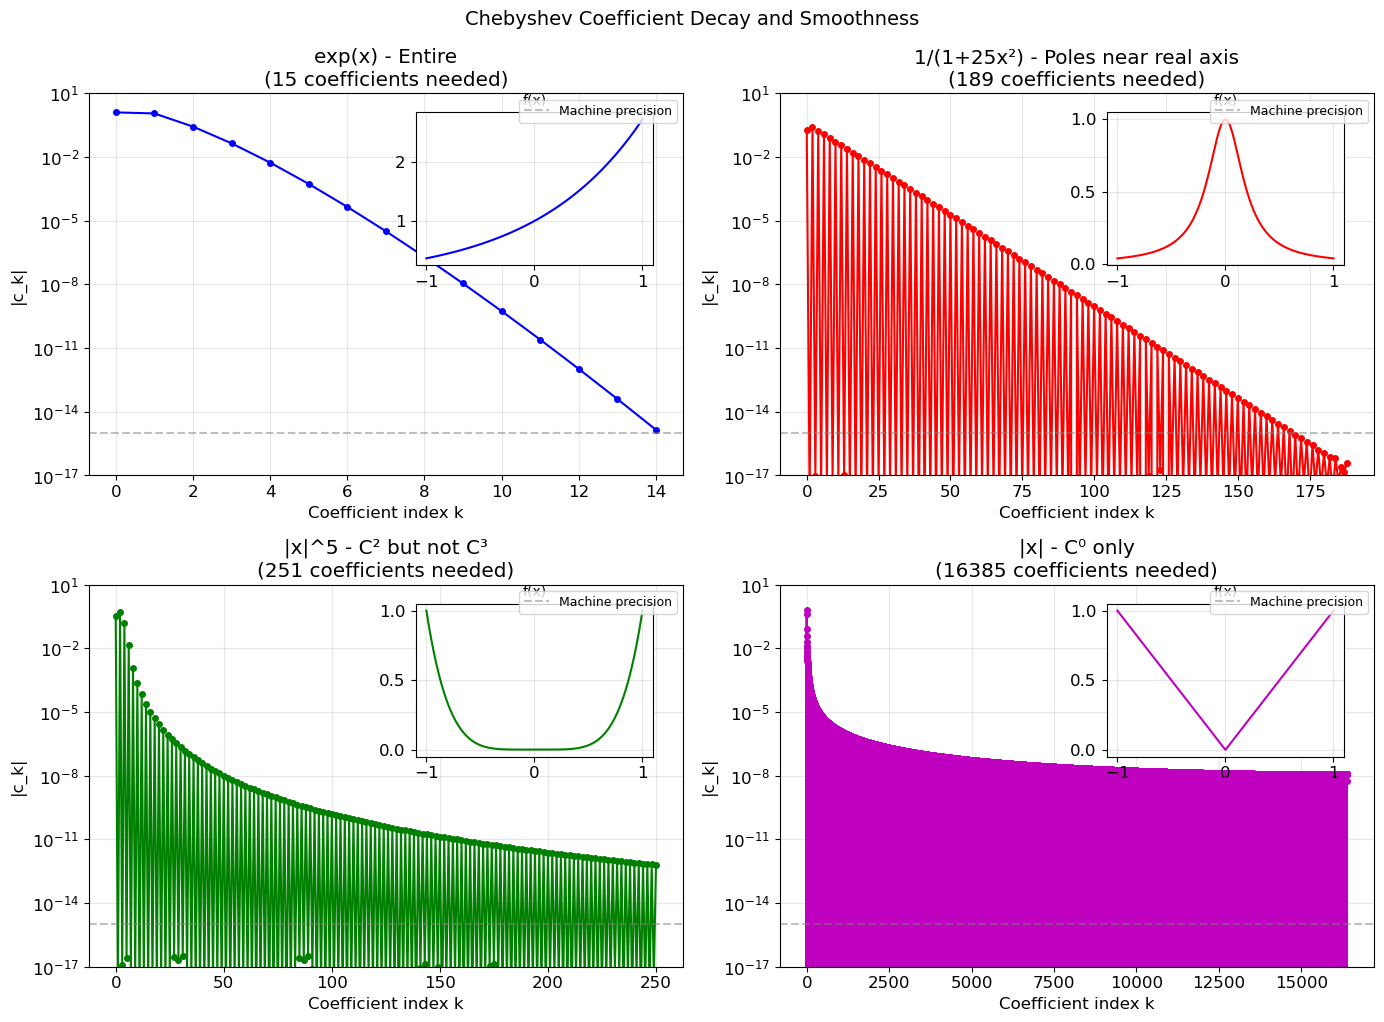

In [6]:
# Create functions with different smoothness properties
f_analytic = Fun(lambda x: np.exp(x), [-1, 1])  # Entire function
f_smooth = Fun(lambda x: 1/(1 + 25*x**2), [-1, 1])  # Analytic but with poles near [-1,1]
f_c2 = Fun(lambda x: np.abs(x)**5, [-1, 1])  # C^2 but not C^3
f_c0 = Fun(lambda x: np.abs(x), [-1, 1])  # C^0, derivative discontinuous at 0

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

functions = [
    (f_analytic, 'exp(x) - Entire', 'b'),
    (f_smooth, '1/(1+25x²) - Poles near real axis', 'r'),
    (f_c2, '|x|^5 - C² but not C³', 'g'),
    (f_c0, '|x| - C⁰ only', 'm')
]

xx = np.linspace(-1, 1, 500)

for ax, (f, title, color) in zip(axes.flat, functions):
    coeffs = np.abs(f.coeffs.flatten())
    n = len(coeffs)
    
    # Plot function (inset)
    ax_inset = ax.inset_axes([0.55, 0.55, 0.4, 0.4])
    ax_inset.plot(xx, f(xx), color=color, linewidth=1.5)
    ax_inset.set_title('f(x)', fontsize=10)
    ax_inset.grid(True, alpha=0.3)
    
    # Plot coefficient decay
    ax.semilogy(np.arange(n), coeffs, 'o-', color=color, markersize=4)
    ax.axhline(1e-15, color='gray', linestyle='--', alpha=0.5, label='Machine precision')
    ax.set_xlabel('Coefficient index k')
    ax.set_ylabel('|c_k|')
    ax.set_title(f'{title}\n({n} coefficients needed)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(1e-17, 10)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.suptitle('Chebyshev Coefficient Decay and Smoothness', y=1.02, fontsize=14)
plt.show()

**Observations:**
- **exp(x)**: Entire function → geometric decay → only ~15 coefficients needed
- **1/(1+25x²)**: Poles at $\pm i/5$ limit convergence → ~60 coefficients
- **|x|⁵**: Limited smoothness → algebraic decay → ~100 coefficients
- **|x|**: Non-smooth → very slow decay → many coefficients needed

## 5. The Runge Phenomenon: Chebyshev vs Equidistant

For smooth functions, polynomial interpolation at **Chebyshev points** converges exponentially, while interpolation at **equidistant points** can diverge catastrophically.

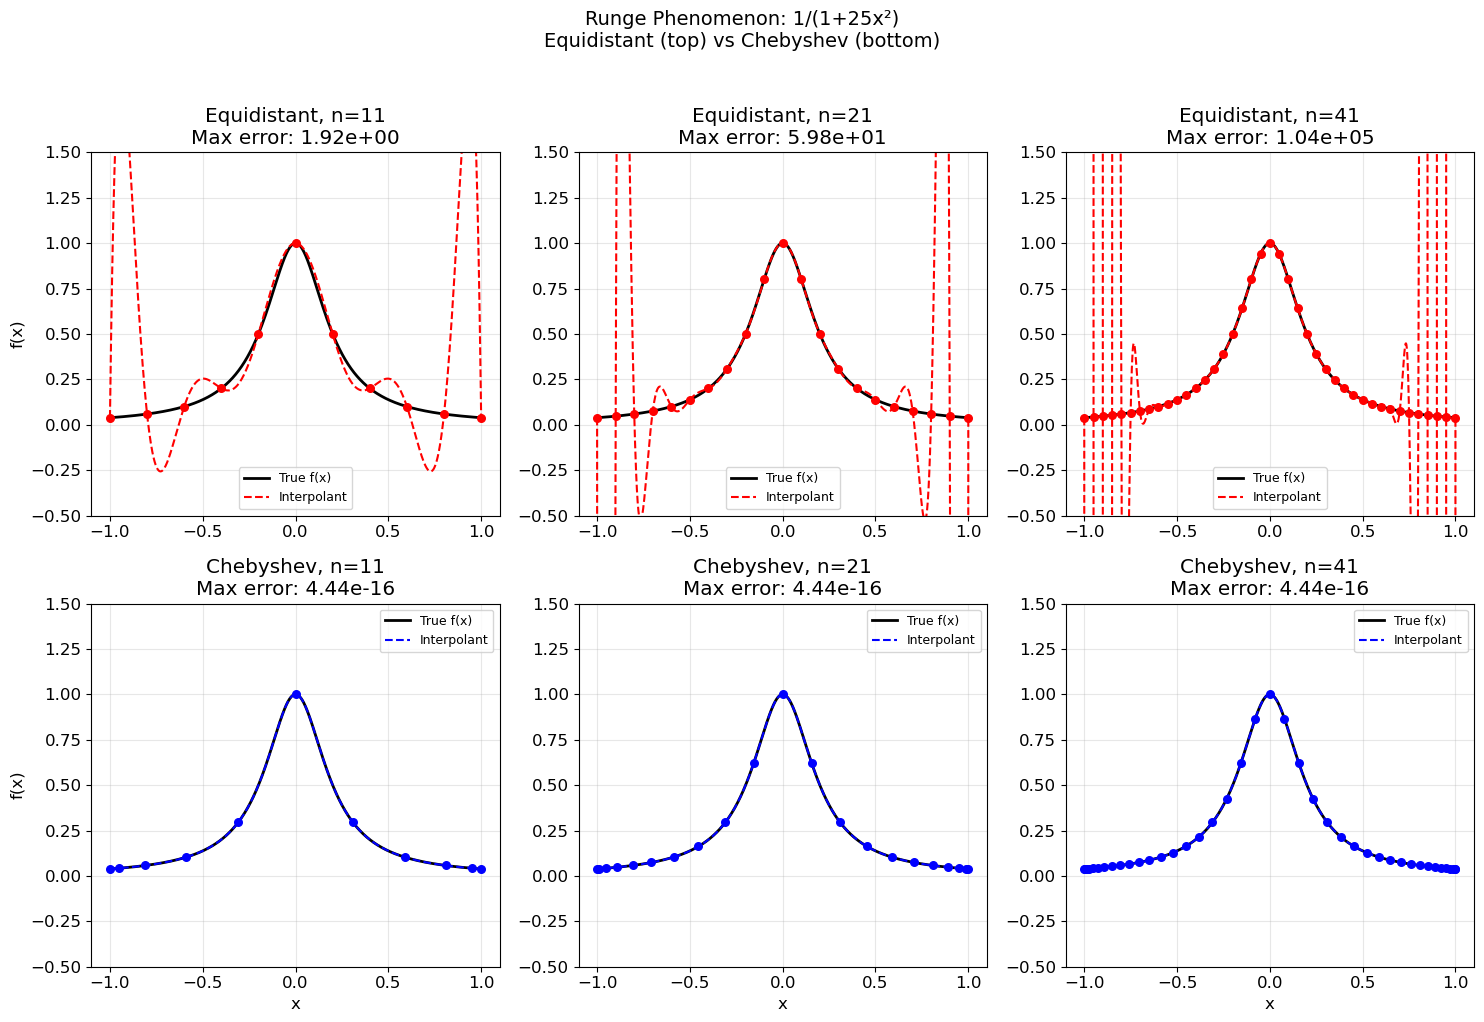

In [7]:
def runge(x):
    """The infamous Runge function."""
    return 1 / (1 + 25*x**2)

def lagrange_interp(x_data, f_data, x_eval):
    """Lagrange interpolation at arbitrary points."""
    n = len(x_data)
    result = np.zeros_like(x_eval)
    for i in range(n):
        Li = np.ones_like(x_eval)
        for j in range(n):
            if i != j:
                Li *= (x_eval - x_data[j]) / (x_data[i] - x_data[j])
        result += f_data[i] * Li
    return result

# Fine grid for plotting
xx = np.linspace(-1, 1, 1000)
f_true = runge(xx)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for col, n in enumerate([11, 21, 41]):
    # Equidistant interpolation
    x_eq = np.linspace(-1, 1, n)
    f_eq = runge(x_eq)
    p_eq = lagrange_interp(x_eq, f_eq, xx)
    err_eq = np.max(np.abs(p_eq - f_true))
    
    # Chebyshev interpolation using funpy
    f_cheb = Fun(runge, [-1, 1], n=n)  # Force specific n
    p_cheb = f_cheb(xx)
    err_cheb = np.max(np.abs(p_cheb - f_true))
    
    # Plot equidistant
    ax = axes[0, col]
    ax.plot(xx, f_true, 'k-', linewidth=2, label='True f(x)')
    ax.plot(xx, p_eq, 'r--', linewidth=1.5, label='Interpolant')
    ax.scatter(x_eq, f_eq, c='r', s=30, zorder=5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_title(f'Equidistant, n={n}\nMax error: {err_eq:.2e}')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    if col == 0:
        ax.set_ylabel('f(x)')
    
    # Plot Chebyshev
    ax = axes[1, col]
    x_cheb, _, _, _ = chebpts_type2(n)
    ax.plot(xx, f_true, 'k-', linewidth=2, label='True f(x)')
    ax.plot(xx, p_cheb, 'b--', linewidth=1.5, label='Interpolant')
    ax.scatter(x_cheb, runge(x_cheb), c='b', s=30, zorder=5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_title(f'Chebyshev, n={n}\nMax error: {err_cheb:.2e}')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    if col == 0:
        ax.set_ylabel('f(x)')

plt.suptitle("Runge Phenomenon: 1/(1+25x²)\nEquidistant (top) vs Chebyshev (bottom)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

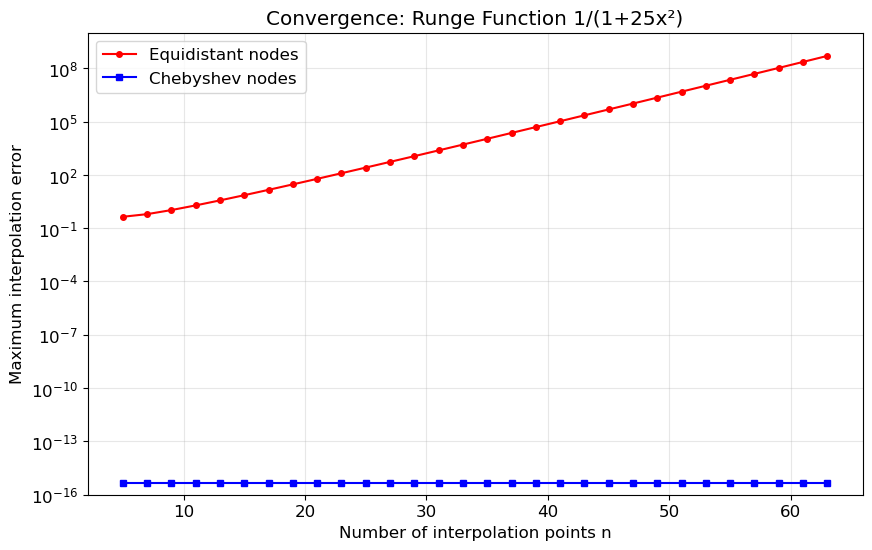

Equidistant interpolation DIVERGES as n increases!
Chebyshev interpolation CONVERGES exponentially.


In [8]:
# Convergence comparison
ns = np.arange(5, 65, 2)
err_equidistant = []
err_chebyshev = []

for n in ns:
    # Equidistant
    x_eq = np.linspace(-1, 1, n)
    try:
        p_eq = lagrange_interp(x_eq, runge(x_eq), xx)
        err_equidistant.append(np.max(np.abs(p_eq - f_true)))
    except:
        err_equidistant.append(np.nan)
    
    # Chebyshev
    f_cheb = Fun(runge, [-1, 1], n=n)
    err_chebyshev.append(np.max(np.abs(f_cheb(xx) - f_true)))

plt.figure(figsize=(10, 6))
plt.semilogy(ns, err_equidistant, 'ro-', label='Equidistant nodes', markersize=4)
plt.semilogy(ns, err_chebyshev, 'bs-', label='Chebyshev nodes', markersize=4)
plt.xlabel('Number of interpolation points n')
plt.ylabel('Maximum interpolation error')
plt.title('Convergence: Runge Function 1/(1+25x²)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(1e-16, 1e10)
plt.show()

print("Equidistant interpolation DIVERGES as n increases!")
print("Chebyshev interpolation CONVERGES exponentially.")

## 6. Differentiation and Integration

funpy makes calculus operations trivial—and spectrally accurate!

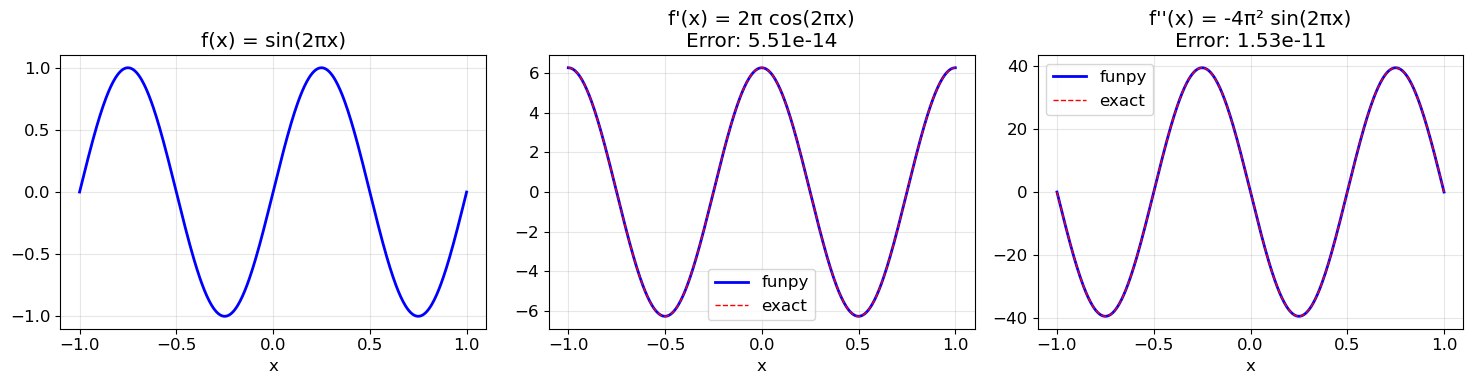

In [9]:
# Create a function
f = Fun(lambda x: np.sin(2*np.pi*x), [-1, 1])

# Differentiation
f_prime = np.diff(f)  # First derivative
f_2prime = np.diff(f, n=2)  # Second derivative

# Exact derivatives for comparison
f_prime_exact = lambda x: 2*np.pi*np.cos(2*np.pi*x)
f_2prime_exact = lambda x: -4*np.pi**2*np.sin(2*np.pi*x)

xx = np.linspace(-1, 1, 500)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.plot(xx, f(xx), 'b-', linewidth=2)
ax.set_title('f(x) = sin(2πx)')
ax.set_xlabel('x')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(xx, f_prime(xx), 'b-', linewidth=2, label='funpy')
ax.plot(xx, f_prime_exact(xx), 'r--', linewidth=1, label='exact')
err1 = np.max(np.abs(f_prime(xx) - f_prime_exact(xx)))
ax.set_title(f"f'(x) = 2π cos(2πx)\nError: {err1:.2e}")
ax.set_xlabel('x')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(xx, f_2prime(xx), 'b-', linewidth=2, label='funpy')
ax.plot(xx, f_2prime_exact(xx), 'r--', linewidth=1, label='exact')
err2 = np.max(np.abs(f_2prime(xx) - f_2prime_exact(xx)))
ax.set_title(f"f''(x) = -4π² sin(2πx)\nError: {err2:.2e}")
ax.set_xlabel('x')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Integration (definite integral)
f = Fun(lambda x: np.exp(x), [-1, 1])
integral = np.sum(f).item()  # Integral over the domain

exact_integral = np.exp(1) - np.exp(-1)
print(f"funpy integral of exp(x) from -1 to 1: {integral}")
print(f"Exact value (e - 1/e):                  {exact_integral}")
print(f"Error:                                  {abs(integral - exact_integral):.2e}")

funpy integral of exp(x) from -1 to 1: 2.3504023872876028
Exact value (e - 1/e):                  2.3504023872876028
Error:                                  0.00e+00


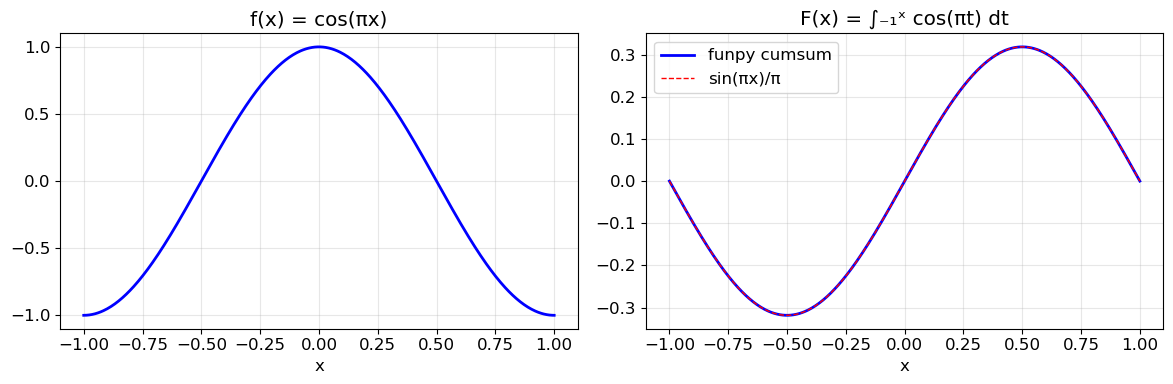

In [11]:
# Indefinite integral (cumulative sum)
f = Fun(lambda x: np.cos(np.pi*x), [-1, 1])
F = np.cumsum(f)  # Indefinite integral starting from left endpoint

# Exact: integral of cos(πx) from -1 to x is (1/π)[sin(πx) - sin(-π)] = sin(πx)/π
F_exact = lambda x: np.sin(np.pi*x) / np.pi

xx = np.linspace(-1, 1, 500)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(xx, f(xx), 'b-', linewidth=2)
ax.set_title('f(x) = cos(πx)')
ax.set_xlabel('x')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(xx, F(xx), 'b-', linewidth=2, label='funpy cumsum')
ax.plot(xx, F_exact(xx), 'r--', linewidth=1, label='sin(πx)/π')
ax.set_title('F(x) = ∫₋₁ˣ cos(πt) dt')
ax.set_xlabel('x')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Arithmetic with Functions

funpy supports arithmetic operations directly on function objects.

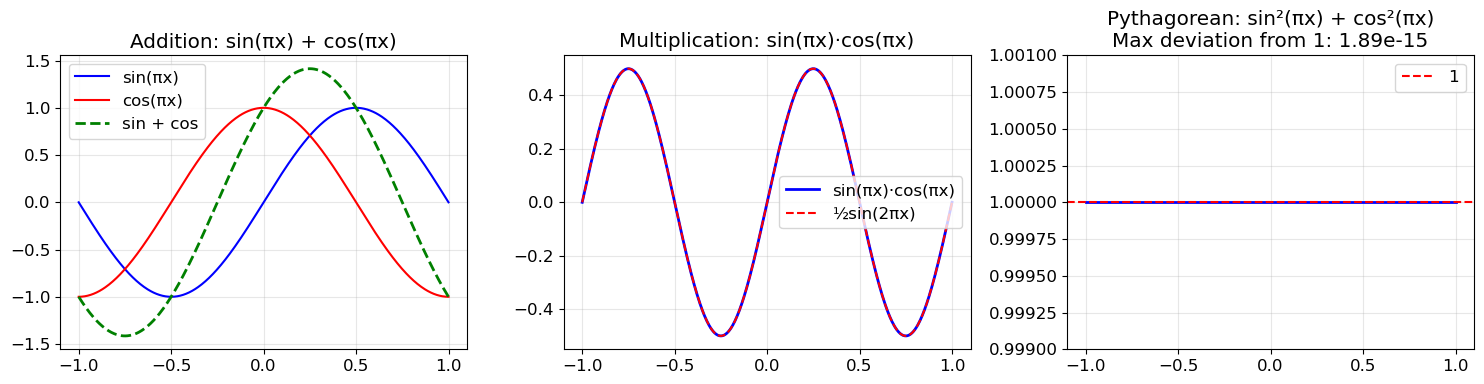

In [12]:
f = Fun(lambda x: np.sin(np.pi*x), [-1, 1])
g = Fun(lambda x: np.cos(np.pi*x), [-1, 1])

# Function arithmetic
h1 = f + g          # Addition
h2 = f * g          # Multiplication
h3 = f ** 2 + g ** 2  # Should be 1 (Pythagorean identity)

xx = np.linspace(-1, 1, 500)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.plot(xx, f(xx), 'b-', label='sin(πx)')
ax.plot(xx, g(xx), 'r-', label='cos(πx)')
ax.plot(xx, h1(xx), 'g--', linewidth=2, label='sin + cos')
ax.set_title('Addition: sin(πx) + cos(πx)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(xx, h2(xx), 'b-', linewidth=2, label='sin(πx)·cos(πx)')
ax.plot(xx, 0.5*np.sin(2*np.pi*xx), 'r--', label='½sin(2πx)')
ax.set_title('Multiplication: sin(πx)·cos(πx)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(xx, h3(xx), 'b-', linewidth=2)
ax.axhline(1, color='r', linestyle='--', label='1')
ax.set_title(f'Pythagorean: sin²(πx) + cos²(πx)\nMax deviation from 1: {np.max(np.abs(h3(xx) - 1)):.2e}')
ax.set_ylim(0.999, 1.001)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Example: Solving $\int_{-1}^{1} f(x)^2 \, dx$

Following the hybrid approach from the lecture notes: we can square in value space and integrate in coefficient space.

In [13]:
# Compute ∫ f(x)² dx
f = Fun(lambda x: np.sin(np.pi*x), [-1, 1])

# Square and integrate
f_squared = f ** 2
integral = np.sum(f_squared).item()

# Exact value: ∫₋₁¹ sin²(πx) dx = ∫₋₁¹ (1-cos(2πx))/2 dx = 1
exact = 1.0

print(f"funpy: ∫₋₁¹ sin²(πx) dx = {integral}")
print(f"Exact:                    {exact}")
print(f"Error:                    {abs(integral - exact):.2e}")

funpy: ∫₋₁¹ sin²(πx) dx = 0.9999999999999998
Exact:                    1.0
Error:                    2.22e-16


## 9. Finding Roots and Extrema

funpy can find roots and extrema of functions.

Roots of x⁵ - x = x(x²-1)(x²+1)/... = x(x-1)(x+1):
funpy roots: [-1.00000000e+00 -3.01681171e-17  1.00000000e+00]
Exact roots: [-1, 0, 1]


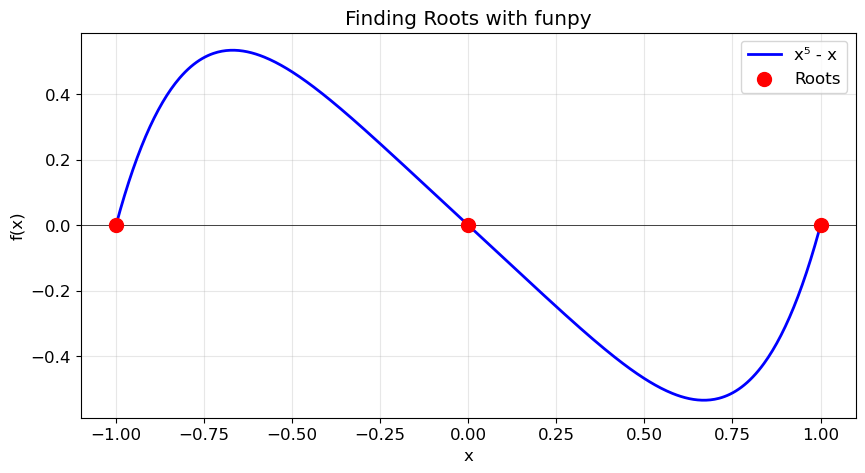

In [14]:
# Find roots of a Chebyshev polynomial
f = Fun(lambda x: x**5 - x, [-1, 1])

# Find roots
roots = f.roots()
print("Roots of x⁵ - x = x(x²-1)(x²+1)/... = x(x-1)(x+1):")
print(f"funpy roots: {np.sort(roots)}")
print(f"Exact roots: [-1, 0, 1]")

xx = np.linspace(-1, 1, 500)
plt.figure(figsize=(10, 5))
plt.plot(xx, f(xx), 'b-', linewidth=2, label='x⁵ - x')
plt.scatter(roots, np.zeros_like(roots), c='r', s=100, zorder=5, label='Roots')
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Finding Roots with funpy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary

**funpy** provides a powerful interface for working with functions through Chebyshev interpolation:

1. **Automatic adaptivity**: Determines the number of coefficients needed automatically
2. **Fast transforms**: $O(n \log n)$ conversion between values and coefficients via DCT
3. **Spectral accuracy**: Exponential convergence for smooth functions
4. **Easy calculus**: Differentiation, integration, and root-finding are built-in
5. **No Runge phenomenon**: Chebyshev points avoid the divergence seen with equidistant interpolation

This is the foundation for **spectral methods** in scientific computing!